In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

# Create the data

In [2]:
df = pd.read_csv('survey.csv') # read csv file as pandas data frame

In [3]:
feature_name_list = list(df)
list(feature_name_list)

['Timestamp',
 'Age',
 'Gender',
 'Country',
 'state',
 'self_employed',
 'family_history',
 'treatment',
 'work_interfere',
 'no_employees',
 'remote_work',
 'tech_company',
 'benefits',
 'care_options',
 'wellness_program',
 'seek_help',
 'anonymity',
 'leave',
 'mental_health_consequence',
 'phys_health_consequence',
 'coworkers',
 'supervisor',
 'mental_health_interview',
 'phys_health_interview',
 'mental_vs_physical',
 'obs_consequence',
 'comments']

In [4]:
df_selected = df[[ 'Age', 'Gender','treatment']] # Choose desired features and labels(classes)
df_selected

,Age,Gender,treatment
0,37,Female,Yes
1,44,M,No
2,32,Male,No
3,31,Male,Yes
4,31,Male,No
...,...,...,...
1254,26,male,Yes
1255,32,Male,Yes
1256,34,male,Yes
1257,46,f,No


In [5]:
print('\033[1m' + 'Total empty values in the Dataset :' + '\033[0m' , df_selected.isnull().sum().sum())

Total empty values in the Dataset : 0


In [6]:
    for col in df_selected.columns:
        print('\033[1m' + 'Unique values in {} :'.format(col) + '\033[0m',len(df_selected[col].unique()))

Unique values in Age : 53
Unique values in Gender : 49
Unique values in treatment : 2


In [7]:
print('\033[1m' + 'Unique values in updated Gender column :' + '\033[0m', df_selected.Gender.unique())
print('\033[1m' + 'Range of column Age :' + '\033[0m', (df_selected.Age.min(), df_selected.Age.max()))
print('\033[1m' + 'Unique values in treatment column :' + '\033[0m', df_selected.treatment.unique())

Unique values in updated Gender column : ['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne' 'Agender'
 'cis-female/femme' 'Guy (-ish) ^_^' 'male leaning androgynous' 'Male '
 'Man' 'Trans woman' 'msle' 'Neuter' 'Female (trans)' 'queer'
 'Female (cis)' 'Mail' 'cis male' 'A little about you' 'Malr' 'p' 'femail'
 'Cis Man' 'ostensibly male, unsure what that really means']
Range of column Age : (-1726, 99999999999)
Unique values in treatment column : ['Yes' 'No']


In [8]:
# Feature label encoding 

age = []
for i in df_selected.Age:
    if (i<18) or (i>99):
        age.append(31)   # Assign 31 as Median age
    else:
        age.append(i)

df_selected['Age'] = age

other  = ['A little about you', 'p', 'Nah', 'Enby', 'Trans-female','something kinda male?','queer/she/they','non-binary','All','fluid', 'Genderqueer','Androgyne', 'Agender','Guy (-ish) ^_^', 'male leaning androgynous','Trans woman','Neuter', 'Female (trans)','queer','ostensibly male, unsure what that really means','trans']
male   = ['male', 'Male','M', 'm', 'Male-ish', 'maile','Cis Male','Mal', 'Male (CIS)','Make','Male ', 'Man', 'msle','cis male', 'Cis Man','Malr','Mail']
female = ['Female', 'female','Cis Female', 'F','f','Femake', 'woman','Female ','cis-female/femme','Female (cis)','femail','Woman','female']

df_selected['Gender'].replace(to_replace = other, value = 3, inplace=True)
df_selected['Gender'].replace(to_replace = male, value = 1, inplace=True)
df_selected['Gender'].replace(to_replace = female, value = 2, inplace=True)
df_selected['treatment'].replace(to_replace = 'Yes', value = 1, inplace=True)
df_selected['treatment'].replace(to_replace = 'No', value = 0, inplace=True)

In [9]:
print('\033[1m' + 'Unique values in updated Gender column :' + '\033[0m', df_selected.Gender.unique())
print('\033[1m' + 'Age range:' + '\033[0m', (df_selected.Age.min(), df_selected.Age.max()))
print('\033[1m' + 'Unique values in updated treatment column :' + '\033[0m', df_selected.treatment.unique())

Unique values in updated Gender column : [2 1 3]
Age range: (18, 72)
Unique values in updated treatment column : [1 0]


In [10]:
for col in df_selected.columns:
    print('\033[1m' + 'Number of unique values in {} :'.format(col) + '\033[0m',len(df_selected[col].unique()))

Number of unique values in Age : 45
Number of unique values in Gender : 3
Number of unique values in treatment : 2


In [21]:
# Define features and labels (that contin class information)
test_ratio = 0.2
seed = 0
X = np.array(df_selected.drop('treatment', axis =1)) # X contains all feature values as array
y = np.array(df_selected.treatment) # y contains class values as array
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=seed, stratify=y)

# Data embedding circuits

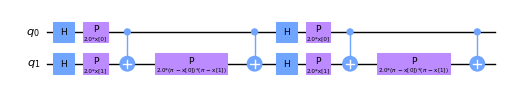

In [25]:
feature_dim = X.shape[1]
feature_map_rep = 2
ent = 'linear'

fmap_zz = ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)
fmap_zz.decompose().draw('mpl', scale=0.7)

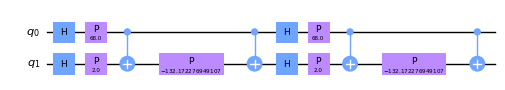

In [26]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x_train[0])}).decompose().draw('mpl', scale=0.7)

# Anstaz

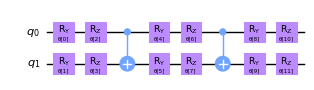

In [28]:
rotations = ['ry', 'rz']
var_form_rep = 2


ansatz_tl = TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)
ansatz_tl.decompose().draw('mpl', scale=0.7)

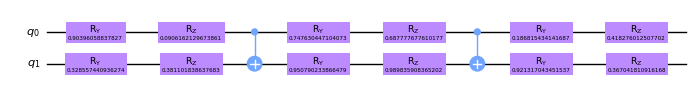

In [29]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)

# Quantum Neural Network

## CircuitQNN

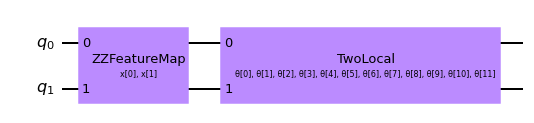

In [30]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw('mpl')

In [31]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [33]:
qasm_sim = Aer.get_backend('qasm_simulator')
qinst = QuantumInstance(qasm_sim, 2048)

In [34]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

### Forward pass

In [36]:
# The result of the neural network of the shape (output_shape).
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.20019531, 0.79980469]])

### Backward pass

In [38]:
# The result of the neural network of the backward pass, i.e., a tuple with the gradients
# for input and weights of shape (output_shape, num_input) and
# (output_shape, num_weights), respectively.
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.27050781,  0.07666016,  0.04370117,  0.1340332 ,
         -0.06201172,  0.01025391,  0.00756836, -0.06225586,
          0.03295898,  0.00488281,  0.00854492,  0.00146484],
        [ 0.27050781, -0.07666016, -0.04370117, -0.1340332 ,
          0.06201172, -0.01025391, -0.00756836,  0.06225586,
         -0.03295898, -0.00488281, -0.00854492, -0.00146484]]])

## OpflowQNN

In [39]:
obs_parity = Z ^ feature_dim
obs_one_qubit = I ^ (feature_dim - 1) ^ Z
obs_one_qubit

PauliOp(Pauli('IZ'), coeff=1.0)

In [40]:
# For an introduction to the Opflow module, see
# https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/operators/01_operator_flow.ipynb
operator = ~StateFn(obs_one_qubit) @ StateFn(var_circuit)
operator

ComposedOp([OperatorStateFn(PauliOp(Pauli('IZ'), coeff=1.0), coeff=1.0, is_measurement=True), CircuitStateFn(<qiskit.circuit.library.data_preparation.zz_feature_map.ZZFeatureMap object at 0x7f78defe1588>, coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)

In [41]:
gradient = Gradient(grad_method="param_shift")
op_qnn = OpflowQNN(operator,
                   input_params=fmap_zz.parameters,
                   weight_params=ansatz_tl.parameters,
                   gradient=gradient,
                   quantum_instance=qinst)

### Forward pass

In [43]:
output = op_qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 1)


array([[-0.61035156]])

### Backward pass

In [46]:
_, update = op_qnn.backward(x_train[0], weights)
print(update.shape)
update

(1, 1, 12)


array([[[-0.52978516,  0.17773438,  0.10205078,  0.27587891,
         -0.13720703,  0.03662109, -0.00683594, -0.09375   ,
          0.09033203,  0.01708984,  0.00439453, -0.00732422]]])

# Train a Neural Network Classifier with CircuitQNN

In [47]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [48]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [50]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train])
x_test_norm = np.array([x/np.linalg.norm(x) for x in x_test])

vqc = vqc.fit(x_train_norm, y_train_1h)

3 - 1238.8160029273658
6 - 1105.699969717439
9 - 1103.8471960149602
12 - 1087.1651203655317
15 - 998.942913801754
18 - 998.7947533683329
21 - 999.9462042969628
24 - 999.5868073379602
27 - 1000.1811492832605
30 - 998.2143420435004
33 - 998.7126327321449
36 - 997.4813006846783
39 - 998.4611984095814
42 - 998.0548591952358
45 - 999.379831628513
48 - 998.1864372092567
51 - 999.4824757956089
54 - 997.6021845709323
57 - 997.540874535275
60 - 997.4873037485211
63 - 996.7636219424867
66 - 997.9304240787903
69 - 998.9470159272436
72 - 997.4296944285245
75 - 999.695167099525
78 - 1000.7951935604651
81 - 1000.0386948134732
84 - 999.6259285555522
87 - 999.8116140519485
90 - 999.1299086667993
93 - 999.0611831603826
96 - 997.6559597689641
99 - 997.4431685730742
102 - 998.3258280366572
105 - 996.4684288315134
108 - 997.8099226976071
111 - 998.6982490364089
114 - 998.0328189544917
117 - 997.4289686084596
120 - 997.3344596882473
123 - 998.7310331967427
126 - 997.6720806628688
129 - 996.9558980645054
13

In [51]:
score_train = vqc.score(x_train_norm, y_train_1h)
score_test = vqc.score(x_test_norm, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.48758689175769615
Score on the test set 0.5357142857142857


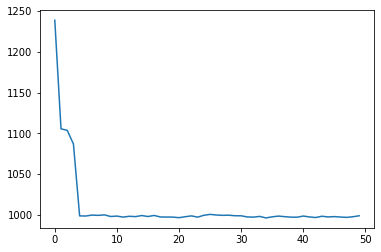

In [52]:
plt.plot(loss_recorder)

# Train a Neural Network Classifier with OpflowQNN and Gradient Descent

In [53]:
y_train_pm = np.array([-1 if y==0 else y for y in y_train])
y_test_pm = np.array([-1 if y==0 else y for y in y_test])
y_train.shape

(1007,)

In [54]:
max_itr = 10
gd_opt = GradientDescent(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
op_vqc = NeuralNetworkClassifier(neural_network=op_qnn,
                                 loss=L2Loss(),
                                 one_hot=False,
                                 optimizer=gd_opt,
                                 initial_point=initial_point)

op_vqc = op_vqc.fit(x_train, y_train_pm)

1 - 1156.9786386489868
2 - 1133.451862335205
3 - 1181.2949352264404
4 - 1288.8717184066772
5 - 1287.4318761825562
6 - 1196.5431051254272
7 - 1132.8619813919067
8 - 1276.2540645599365
9 - 1359.6065044403076
10 - 1087.3072519302368


In [55]:
score_train = op_vqc.score(x_train, y_train_pm)
score_test = op_vqc.score(x_test, y_test_pm)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.5074478649453823
Score on the test set 0.49603174603174605


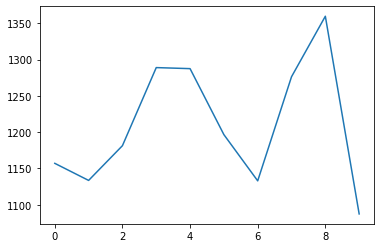

In [56]:
plt.plot(loss_recorder)